# Classifing audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo @ 2019<br/>
<br/>
This notebook if part of my project "Urban sounds classification with Covnolutional Neural Networks" on my Githubat: https://github.com/GorillaBus/urban-audio-classifier.<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

## Appendix II
### Normalized audio amplitudes vs Original dataset amplitudes

The same sound source can be captured with different amplitude levels depending on facts like recording settings, microphone characteristics, distance from the sensor to the source, etc.<br/>
<br/>

Normalizing the average peak amplitude in audio files seems to be a very common normalization process in speech recognition. It may also seem somewhat intuitive at first to normalize audio volumes; by normalizing the average amplitude of every sample in our dataset to the same value we are taking all those values to the same scale. But, at the same time, this amplitude difference between files in our dataset may also introduce a regularization effect that may help generalize better.<br/>
<br/>

We want to run an explicit test where we compare how a model perform when trained with normalized and varying average amplitude to resolve if we may normalize this feature or even if we may also want to use amplitude variation intentionally to augment data.<br/>
<br/>
<br/>

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import random
from datetime import datetime 

from keras import backend as keras_backend
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Define general variables/settings

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

In [3]:
# Load the metadata from the generated CSV
metadata = pd.read_csv(metadata_path)

## Load data
We are loading:
* Data v1: the original version of the MFCC features extracted from the original audio
* Data v2: MFCC features extracted from the normalized average peak amplitude dataset from appendix 1.

In [11]:
# Load both datasets: normalized (v2) and original (v1)
num_samples = len(metadata)

# Original
X_orig = np.load("data/X-v1.npy")[0:num_samples]
y_orig = np.load("data/y-v1.npy")[0:num_samples]

# Features from the Normalized Avg Peak Amp dataset
X_norm = np.load("data/X-v2.npy")[0:num_samples]
y_norm = np.load("data/y-v2.npy")[0:num_samples]

## Define helper functions

In [12]:
# Randomize indexes
def randomize(total):
    indexes = list(range(0, total))
    
    # Randomize indexes
    random.shuffle(indexes)

    # Divide the indexes into Train and Test
    test_split_pct = 20
    split_offset = math.floor(test_split_pct * total / 100)

    # Split the metadata
    test_split_idx = indexes[0:split_offset]
    train_split_idx = indexes[split_offset:total]
    test_meta = metadata.iloc[test_split_idx]
    train_meta = metadata.iloc[train_split_idx]
    
    return [test_split_idx, train_split_idx, test_meta, train_meta]


# Split data
le = LabelEncoder()
def split(X, y, splits):
    # Split the features the with the same indexes
    X_test = np.take(X, splits[0], axis=0)
    y_test = np.take(y, splits[0], axis=0)
    X_train = np.take(X, splits[1], axis=0)
    y_train = np.take(y, splits[1], axis=0)
    
    # One-Hot
    y_test_encoded = to_categorical(le.fit_transform(y_test))
    y_train_encoded = to_categorical(le.fit_transform(y_train))

    # Reshape to fit the network input (channel last!)
    X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
    X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)
    
    return [X_train, y_train_encoded, X_test, y_test_encoded]


# Create model
def create_model(input_shape, num_labels):
    model = Sequential()

    # Conv 1
    model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))

    # Conv 2
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 3
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 4
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))

    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())

    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    # Compile model
    adam = Adam(lr=1.5e-3, beta_1=0.99, beta_2=0.999)
    model.compile(
        loss='categorical_crossentropy', 
        metrics=['accuracy'], 
        optimizer=adam)

    return model

def train_model(model, X_train, y_train, X_test, y_test, num_epochs, batch_size):
    history = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test),
                        verbose=1)

    # Evaluate on train set
    train_score = model.evaluate(X_test, y_test, verbose=1)
    train_loss = train_score[0]
    train_acc = 100 * train_score[1]

    # Evaluate on test set
    test_score = model.evaluate(X_train, y_train, verbose=1)
    test_loss = test_score[0]
    test_acc = 100 * test_score[1]

    # Train / Test difference
    loss_diff = round(abs(train_loss - test_loss), 3)
    acc_diff = round(abs(train_acc - test_acc), 3)

    return {
        'history': history, 
        'train_loss': train_loss, 
        'test_loss': test_loss, 
        'train_acc': train_acc, 
        'test_acc': test_acc, 
        'loss_diff': loss_diff, 
        'acc_diff': acc_diff
    }

## Training comparison schedule

* On each round I'm  shuffling the indexes of the data and creating two train/test splits using the same index orders with the two different data sources: original and normalized amplitudes.

* Models are re-defined at the start of each round (they are never re-used).

* A model is marked as 'winner' for a round in which it presents:
    * a difference between Train/Test loss that is lower than 5.5% (a quite permeable value before considering overfitting)
    * a lower test loss value than it's opponent

* Finally we save from the best performing version of each data sources:
    * the model itself
    * its model history

* Default settings: 10 rounds of 20 epochs per model

* A per-round metrics registry is saved as a Pandas dataframe for further analysis

<br/>
<br/>

In [13]:
# Cyclic training settings
rounds = 10
max_loss_diff = 5.5
num_epochs = 20
batch_size = 256

# Register round results
orig_train_losses = []
orig_test_losses = []
orig_train_accuracies = []
orig_test_accuracies = []
orig_loss_diffs = []
orig_acc_diffs = []
norm_train_losses = []
norm_test_losses = []
norm_train_accuracies = []
norm_test_accuracies = []
norm_loss_diffs = []
norm_acc_diffs = []
winners = []

# Best models
best_orig_overall = 100
best_orig_model = None
best_orig_history = None
best_norm_overall = 100
best_norm_model = None
best_norm_history = None

# Input / Output shapes
num_rows = 40
num_columns = 174
num_channels = 1
num_labels = 10
input_shape = (num_rows, num_columns, num_channels)

# Iterate rounds
for idx in range(rounds):

    ### 
    ###   Round setup
    ###

    # Same randomized set for both data sources
    rand_indexes = randomize(num_samples)

    # Prepare both matrices: split() returns [X_train, y_train, X_test, y_test]
    data_orig = split(X_orig, y_orig, rand_indexes)
    data_norm = split(X_norm, y_norm, rand_indexes)


    print(">>> Round #", idx+1)
    

    ### 
    ###   Standard data
    ###

    print(">> Training with STANDARD data...")
    
    # Create momdel (original dataset)
    orig_model = create_model(input_shape, num_labels)

    # Train model and fetch results
    orig_results = train_model(orig_model,
                               data_orig[0], 
                               data_orig[1], 
                               data_orig[2], 
                               data_orig[3], 
                               num_epochs, 
                               batch_size)

    # Register round results
    orig_train_losses.append(orig_results['train_loss'])
    orig_test_losses.append(orig_results['test_loss'])
    orig_train_accuracies.append(orig_results['train_acc'])
    orig_test_accuracies.append(orig_results['test_acc'])
    orig_loss_diffs.append(orig_results['loss_diff'])
    orig_acc_diffs.append(orig_results['acc_diff'])

    # Check best original model
    if (orig_results['loss_diff'] < best_orig_overall):
        best_orig_overall = orig_results['loss_diff']
        best_orig_model = orig_model
        best_orig_history = orig_results['history']
        print(">> * New best model, loss: {}".format(best_orig_overall))



    ### 
    ###   Normalized data
    ###

    print(">> Training with NORMALIZED data...")
    
    # Create momdel (original dataset)
    norm_model = create_model(input_shape, num_labels)

    # Train model and fetch results
    norm_results = train_model(norm_model,
                               data_norm[0], 
                               data_norm[1], 
                               data_norm[2], 
                               data_norm[3], 
                               num_epochs, 
                               batch_size)

    # Register round results
    norm_train_losses.append(norm_results['train_loss'])
    norm_test_losses.append(norm_results['test_loss'])
    norm_train_accuracies.append(norm_results['train_acc'])
    norm_test_accuracies.append(norm_results['test_acc'])
    norm_loss_diffs.append(norm_results['loss_diff'])
    norm_acc_diffs.append(norm_results['acc_diff'])

    # Check best original model
    if (norm_results['loss_diff'] < best_norm_overall):
        best_norm_overall = norm_results['loss_diff']
        best_norm_model = norm_model
        best_norm_history = norm_results['history']
        print(">> * New best model, loss: {}".format(best_norm_overall))

    # Register round winner
    if ((norm_results['loss_diff'] < max_loss_diff) & (norm_results['test_loss'] < orig_results['test_loss'])):
        round_winner = 'normalized'
    elif (orig_results['loss_diff'] < max_loss_diff):
        round_winner = 'standard'
    else:
        round_winner = 'none'
        
    print(">> Round winner: {}".format(round_winner))
    
    # Register winner
    winners.append(round_winner)
    
    print(">>> Finished training tests")

W0722 17:15:07.618076 140275136583488 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 17:15:07.788711 140275136583488 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



>>> Round # 1
>> Training with STANDARD data...


W0722 17:15:07.859950 140275136583488 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 17:15:07.926643 140275136583488 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 17:15:07.927800 140275136583488 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0722 17:15:09.366298 140275136583488 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.f

Train on 6986 samples, validate on 1746 samples
Epoch 1/20
6986/6986 [==============================] - 43s 6ms/step - loss: 1.8878 - acc: 0.3249 - val_loss: 1.4086 - val_acc: 0.5109
Epoch 2/20
6986/6986 [==============================] - 35s 5ms/step - loss: 1.5469 - acc: 0.4453 - val_loss: 1.4271 - val_acc: 0.5000
Epoch 3/20
6986/6986 [==============================] - 35s 5ms/step - loss: 1.4005 - acc: 0.4894 - val_loss: 1.2514 - val_acc: 0.5470
Epoch 4/20
6986/6986 [==============================] - 35s 5ms/step - loss: 1.3182 - acc: 0.5215 - val_loss: 1.2431 - val_acc: 0.5515
Epoch 5/20
6986/6986 [==============================] - 36s 5ms/step - loss: 1.2631 - acc: 0.5465 - val_loss: 1.1245 - val_acc: 0.6134
Epoch 6/20
6986/6986 [==============================] - 36s 5ms/step - loss: 1.2215 - acc: 0.5591 - val_loss: 1.0501 - val_acc: 0.6352
Epoch 7/20
6986/6986 [==============================] - 36s 5ms/step - loss: 1.1701 - acc: 0.5830 - val_loss: 0.9939 - val_acc: 0.6523
Epoch 8

6986/6986 [==============================] - 36s 5ms/step - loss: 0.9814 - acc: 0.6567 - val_loss: 0.8241 - val_acc: 0.7199
Epoch 13/20
6986/6986 [==============================] - 36s 5ms/step - loss: 0.9419 - acc: 0.6685 - val_loss: 0.7944 - val_acc: 0.7371
Epoch 14/20
6986/6986 [==============================] - 36s 5ms/step - loss: 0.9207 - acc: 0.6761 - val_loss: 0.7509 - val_acc: 0.7583
Epoch 15/20
6986/6986 [==============================] - 35s 5ms/step - loss: 0.8937 - acc: 0.6944 - val_loss: 0.7399 - val_acc: 0.7635
Epoch 16/20
6986/6986 [==============================] - 35s 5ms/step - loss: 0.8778 - acc: 0.6968 - val_loss: 0.7053 - val_acc: 0.7703
Epoch 17/20
6986/6986 [==============================] - 35s 5ms/step - loss: 0.8605 - acc: 0.7047 - val_loss: 0.6771 - val_acc: 0.7875
Epoch 18/20
6986/6986 [==============================] - 36s 5ms/step - loss: 0.8371 - acc: 0.7149 - val_loss: 0.6851 - val_acc: 0.7795
Epoch 19/20
6986/6986 [==============================] - 36s

6986/6986 [==============================] - 42s 6ms/step - loss: 1.9040 - acc: 0.3249 - val_loss: 1.7397 - val_acc: 0.4152
Epoch 2/20
6986/6986 [==============================] - 35s 5ms/step - loss: 1.5623 - acc: 0.4455 - val_loss: 1.3886 - val_acc: 0.5063
Epoch 3/20
6986/6986 [==============================] - 36s 5ms/step - loss: 1.4587 - acc: 0.4794 - val_loss: 1.3566 - val_acc: 0.5275
Epoch 4/20
6986/6986 [==============================] - 35s 5ms/step - loss: 1.3658 - acc: 0.5053 - val_loss: 1.4448 - val_acc: 0.4920
Epoch 5/20
6986/6986 [==============================] - 35s 5ms/step - loss: 1.2946 - acc: 0.5395 - val_loss: 1.4045 - val_acc: 0.5086
Epoch 6/20
6986/6986 [==============================] - 36s 5ms/step - loss: 1.2364 - acc: 0.5544 - val_loss: 1.3048 - val_acc: 0.5395
Epoch 7/20
6986/6986 [==============================] - 36s 5ms/step - loss: 1.1792 - acc: 0.5787 - val_loss: 1.2432 - val_acc: 0.5533
Epoch 8/20
6986/6986 [==============================] - 36s 5ms/st

6986/6986 [==============================] - 35s 5ms/step - loss: 0.9590 - acc: 0.6589 - val_loss: 0.7928 - val_acc: 0.7491
Epoch 14/20
6986/6986 [==============================] - 36s 5ms/step - loss: 0.9271 - acc: 0.6854 - val_loss: 0.7536 - val_acc: 0.7595
Epoch 15/20
6986/6986 [==============================] - 37s 5ms/step - loss: 0.8926 - acc: 0.6878 - val_loss: 0.7620 - val_acc: 0.7428
Epoch 16/20
6986/6986 [==============================] - 37s 5ms/step - loss: 0.8768 - acc: 0.6941 - val_loss: 0.7234 - val_acc: 0.7629
Epoch 17/20
6986/6986 [==============================] - 38s 5ms/step - loss: 0.8471 - acc: 0.7040 - val_loss: 0.7048 - val_acc: 0.7715
Epoch 18/20
6986/6986 [==============================] - 36s 5ms/step - loss: 0.8399 - acc: 0.7081 - val_loss: 0.6568 - val_acc: 0.8030
Epoch 19/20
6986/6986 [==============================] - 36s 5ms/step - loss: 0.8091 - acc: 0.7247 - val_loss: 0.6541 - val_acc: 0.7978
Epoch 20/20
6986/6986 [==============================] - 11s

In [16]:
# Save registry
registry = pd.DataFrame({
    'orig_train_loss': orig_train_losses,
    'norm_train_loss': norm_train_losses,
    'orig_test_loss': orig_test_losses,
    'norm_test_loss': norm_test_losses,
    'orig_train_accuracy': orig_train_accuracies,
    'norm_train_accuracy': norm_train_accuracies,
    'orig_test_accuracy': orig_test_accuracies,
    'norm_test_accuracy': norm_test_accuracies,
    'orig_loss_diff': orig_loss_diffs,
    'norm_loss_diff': norm_loss_diffs,
    'orig_acc_diff': orig_acc_diffs,
    'norm_acc_diff': norm_acc_diffs,
    'winner': winners
})

registry

,orig_train_loss,norm_train_loss,orig_test_loss,norm_test_loss,orig_train_accuracy,norm_train_accuracy,orig_test_accuracy,norm_test_accuracy,orig_loss_diff,norm_loss_diff,orig_acc_diff,norm_acc_diff,winner
0,0.670702,0.741416,0.627328,0.693903,79.495991,76.517755,81.563126,78.285142,0.043,0.048,2.067,1.767,standard
1,0.709475,0.702142,0.634842,0.630738,77.892325,76.746850,80.675637,79.630690,0.075,0.071,2.783,2.884,normalized
2,0.670975,0.641146,0.651739,0.609412,78.293242,80.355097,79.645004,81.248211,0.019,0.032,1.352,0.893,normalized
3,0.634869,0.655984,0.646202,0.660062,80.985109,79.266896,79.831091,78.800458,0.011,0.004,1.154,0.466,standard
4,0.692729,0.704548,0.632137,0.655986,79.495991,77.491409,80.131692,79.373032,0.061,0.049,0.636,1.882,standard
5,0.673764,0.727737,0.651732,0.694480,78.465063,75.887743,80.131692,77.139994,0.022,0.033,1.667,1.252,standard
6,0.669093,0.738462,0.615196,0.690921,77.376861,76.288660,80.446608,78.528486,0.054,0.048,3.070,2.240,standard
7,0.749262,0.697644,0.626053,0.588206,74.742268,76.861397,80.647008,81.763527,0.123,0.109,5.905,4.902,normalized
8,0.623060,0.630253,0.602310,0.604900,80.469645,80.297824,81.691955,81.033496,0.021,0.025,1.222,0.736,standard
9,0.697849,0.678349,0.635288,0.613351,78.350515,79.839633,80.518179,81.291154,0.063,0.065,2.168,1.452,normalized


In [26]:

print(">> Train/Test loss difference mean")
print("Standard:", registry['orig_loss_diff'].mean())
print("Normalized:", registry['norm_loss_diff'].mean())

print("\n>> Train/Test accuracy difference mean")
print("Standard:", registry['orig_acc_diff'].mean())
print("Normalized:", registry['norm_acc_diff'].mean())

>> Train/Test loss difference mean
Standard: 0.04920000000000001
Normalized: 0.048400000000000006

>> Train/Test accuracy difference mean
Standard: 2.2024
Normalized: 1.8474000000000004


## Training history comparison

### Train/Test loss comparison

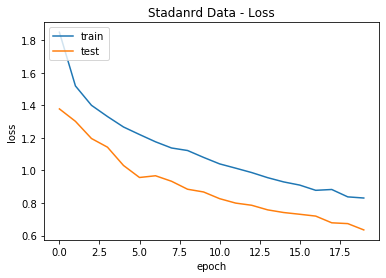

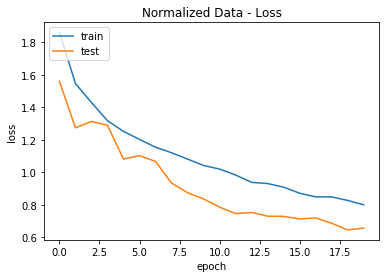

In [17]:
# Standard history for loss
plt.plot(best_orig_history.history['loss'])
plt.plot(best_orig_history.history['val_loss'])
plt.title('Stadanrd Data - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Normalized history for loss
plt.plot(best_norm_history.history['loss'])
plt.plot(best_norm_history.history['val_loss'])
plt.title('Normalized Data - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Train/Test accuracy comparison

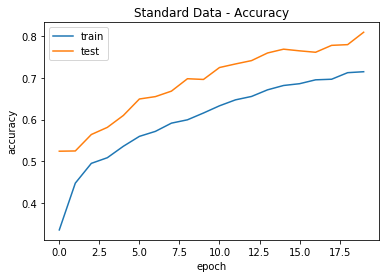

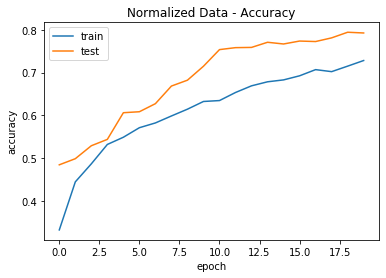

In [20]:
# Standard history for accuracy
plt.plot(best_orig_history.history['acc'])
plt.plot(best_orig_history.history['val_acc'])
plt.title('Standard Data - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Standard history for accuracy
plt.plot(best_norm_history.history['acc'])
plt.plot(best_norm_history.history['val_acc'])
plt.title('Normalized Data - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusions

After 10 rounds of training with both datasets the results are:

* Normalized: 4 wins
* Standard: 6 wins

The overall train/loss difference among all rounds is very similar, but watching the means we can tell that the models trained with normalized average amplitude data got a slight smaller value. Even though, the difference is very small. Also, the Train/Loss gap is more stable with the standard data, what should be better.

Even though, in larger trainings (70+ epochs) I got more overfitted models using the normalized average amplitude data.

In one of the many materials I have been following I found more clues that point to the use of NON-normalized audio for classification tasks like the one here:

*As for normalization after db-scaling, that seems hit or miss depending on your data. From the paper above, the authors found nearly no difference using various normalization techniques for their data.*

Source: https://stackoverflow.com/questions/55513652/which-spectrogram-best-represents-features-of-an-audio-file-for-cnn-based-model/56727927#56727927

Related paper: [A Comparison of Audio Signal Preprocessing Methods for Deep Neural Networks on Music Tagging](https://arxiv.org/abs/1709.01922)

I may continue experimenting with other type of normalization over the data that do not involve modifying the original audio dynamics. Or, in contrast, experiment augmenting data by random amplitude average alteration.